Device set to use cuda:0


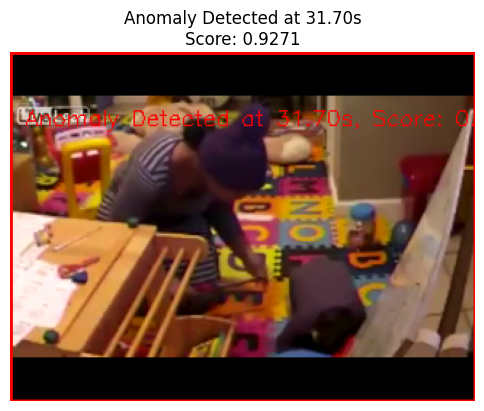

In [6]:
import cv2
import tempfile
import os
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline

# Initialize the video classification pipeline
pipe = pipeline("video-classification", model="Sathwik-kom/anomaly-detector-videomae10",use_fast=True)

def detect_anomalies_in_video(video_path):
    cap = cv2.VideoCapture(video_path)
    min_frames, num_frames = 4, 16
    frames, frame_count = [], 0
    highest_anomaly_score, highlighted_frame, highlighted_timestamp = 0, None, 0
    fps = cap.get(cv2.CAP_PROP_FPS) or 30  # Default FPS to 30 if unavailable
    frame_skip = max(1, int(fps * 0.2))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip == 0:
            frame_resized = cv2.resize(frame, (224, 224))
            frames.append(frame_resized / 255.0)

            if len(frames) >= min(min_frames, len(frames)):
                while len(frames) < num_frames:
                    frames.append(frames[-1])

                temp_video_path = tempfile.mktemp(suffix=".mp4")
                try:
                    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
                    out = cv2.VideoWriter(temp_video_path, fourcc, fps, (224, 224))

                    for f in frames[-num_frames:]:
                        out.write((f * 255).astype("uint8"))
                    out.release()

                    result = pipe(temp_video_path)

                    normal_score = result[0]["score"] if result[0]["label"] == "LABEL_0" else 0
                    anomalous_score = result[0]["score"] if result[0]["label"] == "LABEL_1" else 0

                    timestamp = (frame_count - len(frames) + 1) / fps
                    if anomalous_score > normal_score and anomalous_score > highest_anomaly_score:
                        highest_anomaly_score = anomalous_score
                        highlighted_frame = frame.copy()
                        highlighted_timestamp = timestamp

                finally:
                    try:
                        os.unlink(temp_video_path)
                    except PermissionError:
                        print(f"Warning: Could not delete {temp_video_path}, retrying later.")

                frames.pop(0)

        frame_count += 1

    cap.release()

    if highlighted_frame is not None:
        height, width, _ = highlighted_frame.shape
        cv2.rectangle(highlighted_frame, (0, 0), (width, height), (0, 0, 255), 2)
        text = f"Anomaly Detected at {highlighted_timestamp:.2f}s, Score: {highest_anomaly_score:.4f}"
        cv2.putText(
            highlighted_frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1
        )

        # Convert frame from BGR (OpenCV format) to RGB (Matplotlib format)
        highlighted_frame = cv2.cvtColor(highlighted_frame, cv2.COLOR_BGR2RGB)

        # Display the anomaly frame in Jupyter Notebook
        plt.figure(figsize=(6, 6))
        plt.imshow(highlighted_frame)
        plt.axis("off")
        plt.title(f"Anomaly Detected at {highlighted_timestamp:.2f}s\nScore: {highest_anomaly_score:.4f}")
        plt.show()
    else:
        print("No anomaly detected in the video.")

def main():
    video_path = "test_30/abuse/Abuse025_x264.mp4"  # Provide your video path here
    detect_anomalies_in_video(video_path)

if __name__ == "__main__":
    main()
